In [283]:
import torch
import numpy as np
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.double)

In [284]:
class GoldNanorodSpectrum(torch.nn.Module):
    def __init__(self, eps, em):
        super().__init__()
        self.eps = eps
        self.em = em

    def depolarization_factors(self, aspect_ratio):
        e = torch.sqrt(1 - (1 / aspect_ratio)**2)
        PA = ( (1 - e**2)/ e**2 ) * ( ((1/ (2 * e)) * torch.log((1 + e) / (1 - e))) - 1 )
        PB = 0.5 * (1 - PA)  # PB = PC for a spheroidal particle
        
        return PA, PB, PB

    def extinction_coefficient(self, wavelength, aspect_ratio):
        PA, PB, PC = self.depolarization_factors(aspect_ratio)
        e1, e2 = self.eps(wavelength)

        scale = (2 * np.pi * (self.em**1.5)) / (3 * wavelength)
        gamma = 0.0
        for P in [PA, PB, PC]:
            gj = (e2/ (P**2) )/( ( e1 + (((1-P)/P)*self.em) )**2 + e2**2)
            gamma += gj

        gamma = scale*gamma

        return gamma

    def forward(self, wavelengths, length, radius):
        aspect_ratio = length/radius
        spectra = [self.extinction_coefficient(wl, aspect_ratio) for wl in wavelengths]
        
        return torch.tensor(spectra, requires_grad=True)

In [285]:
class GoldSphereSpectrum(torch.nn.Module):
    def __init__(self, eps, em):
        super().__init__()
        self.eps = eps
        self.em = em

    def extinction_coefficient(self, wavelength, radius):
        e1, e2 = self.eps(wavelength)
        e = torch.complex(e1, e2)

        factor = (e-self.em)/(e+2*self.em)
        scale = (4 * np.pi * (radius**1.5)) / (3 * wavelength)
        gamma = scale*factor.imag 

        return gamma

    def forward(self, wavelengths, radius):
        spectra = [self.extinction_coefficient(wl, radius) for wl in wavelengths]
        
        return torch.tensor(spectra, requires_grad=True)

In [286]:
from torchcubicspline import natural_cubic_spline_coeffs, NaturalCubicSpline

def gold_dielectric_function(x):
    wl = 1239.19/torch.tensor([0.1,0.2,0.3,0.4,0.5,0.5450000,0.5910000,0.6360000,0.64,0.77,0.89,
                           1.02,1.14,1.26,1.39,1.51,1.64,1.76,1.88,2.01,2.13,2.26,2.38,2.50,
                           2.63,2.75,2.88,3.00,3.12,3.25,3.37,3.50,3.62,3.74,3.87,3.99,4.12,
                           4.24,4.36,4.49,4.61,4.74,4.86,4.98,5.11,5.23,5.36,5.48,5.60])
    n_real = torch.tensor([25.17233,7.60352,3.53258,2.02586,1.299091,1.097350,0.9394755,
                       0.8141369,0.92,0.56,0.43,0.35,0.27,0.22,0.17,0.16,0.14,0.13,0.14,
                       0.21,0.29,0.43,0.62,1.04,1.31,1.38,1.45,1.46,1.47,1.46,1.48,1.50,
                       1.48,1.48,1.54,1.53,1.53,1.49,1.47,1.43,1.38,1.35,1.33,1.33,
                       1.32,1.32,1.30,1.31,1.30])
    n_imag = torch.tensor([77.92804,43.34848,29.52751,22.25181,17.77038,16.24777,
                       14.94747,13.82771,13.78,11.21,9.519,8.145,7.15,6.35,5.66,
                       5.08,4.542,4.103,3.697,3.272,2.863,2.455,2.081,1.833,1.849,
                       1.914,1.948,1.958,1.952,1.933,1.895,1.866,1.871,1.883,1.898,
                       1.893,1.889,1.878,1.869,1.847,1.803,1.749,1.688,1.631,1.577,
                       1.536,1.497,1.460,1.427])
    n_r = NaturalCubicSpline(natural_cubic_spline_coeffs(torch.flip(wl, [0]), torch.flip(n_real, [0]).reshape(-1,1)))
    n_i = NaturalCubicSpline(natural_cubic_spline_coeffs(torch.flip(wl, [0]), torch.flip(n_imag, [0]).reshape(-1,1)))
    eps = (n_r.evaluate(x) + 1j*n_i.evaluate(x))**2
   
    return eps.real, eps.imag

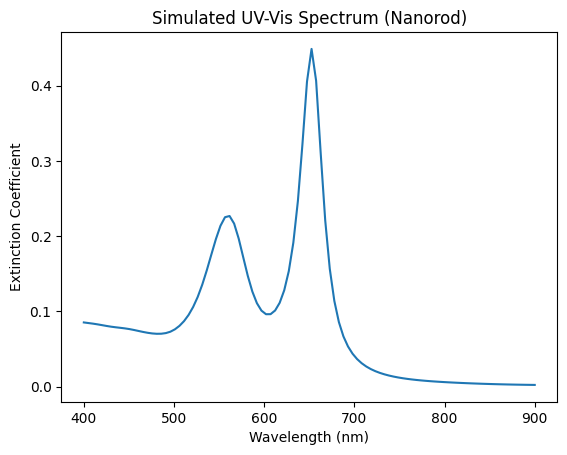

In [287]:
length = 30
radius = 20

wavelengths = torch.linspace(400, 900, 100)

model = GoldNanorodSpectrum(gold_dielectric_function, torch.tensor(4.0))
spectra_rod = model(wavelengths, torch.tensor(length), torch.tensor(radius))

plt.plot(wavelengths, spectra_rod.detach().numpy())
plt.xlabel("Wavelength (nm)")
plt.ylabel("Extinction Coefficient")
plt.title("Simulated UV-Vis Spectrum (Nanorod)")
plt.show()

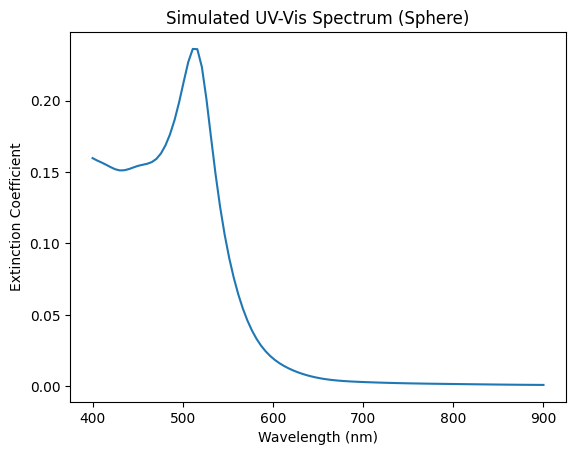

In [288]:
radius = 8

wavelengths = torch.linspace(400, 900, 100)

model = GoldSphereSpectrum(gold_dielectric_function, torch.tensor(1.33))
spectra_sphere = model(wavelengths, torch.tensor(radius))

plt.plot(wavelengths, spectra_sphere.detach().numpy())
plt.xlabel("Wavelength (nm)")
plt.ylabel("Extinction Coefficient")
plt.title("Simulated UV-Vis Spectrum (Sphere)")
plt.show()

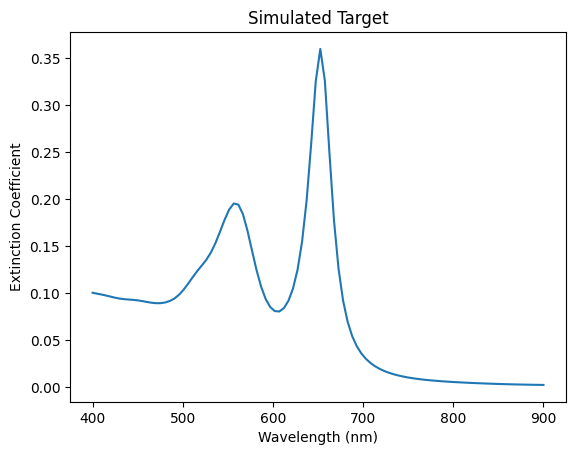

In [289]:
xt = torch.linspace(400, 900, 100).requires_grad_(True)
yt = 0.2*spectra_sphere + 0.8*spectra_rod
plt.plot(wavelengths, yt.clone().detach().numpy())
plt.xlabel("Wavelength (nm)")
plt.ylabel("Extinction Coefficient")
plt.title("Simulated Target")
plt.show()

### AP Distance Loss

In [290]:
from funcshape.functions import Function, SRSF
import optimum_reparamN2 as orN2

def amplitude_phase_distance(t_np, f1, f2, **kwargs):
    t_tensor = torch.tensor(t_np, dtype=f1.dtype, device=f2.device)
    f1_ = Function(t_tensor, f1.reshape(-1,1))
    f2_ = Function(t_tensor, f2.reshape(-1,1))
    q1, q2 = SRSF(f1_), SRSF(f2_)

    delta = q1.qx-q2.qx
    if (delta==0).all():
        amplitude, phase = 0.0, 0.0
    else:
        q1_np = q1.qx.clone().detach().cpu().squeeze().numpy()
        q2_np = q2.qx.clone().detach().cpu().squeeze().numpy()
        
        gamma = orN2.coptimum_reparam(np.ascontiguousarray(q1_np), 
                                      t_np,
                                      np.ascontiguousarray(q2_np), 
                                      kwargs.get("lambda", 0.0),
                                      kwargs.get("grid_dim", 7)
                                    )
        gamma = (t_np[-1] - t_np[0]) * gamma + t_np[0]
    gamma_tensor = torch.from_numpy(gamma)
    gamma_tensor = gamma_tensor.clone().detach().requires_grad_(True)
    warping = Function(t_tensor.squeeze(), gamma_tensor.reshape(-1,1))

    # Compute amplitude
    gam_dev = torch.abs(warping.derivative(warping.x))
    q_gamma = q2(warping.fx)
    y_amplitude = (q1.qx.squeeze() - (q_gamma.squeeze() * torch.sqrt(gam_dev).squeeze())) ** 2
    amplitude = torch.sqrt(torch.trapezoid(y_amplitude, q1.x))

    # Compute phase
    # we define p(\gamma) = \sqrt{\dot{\gamma(t)}} * f(t)
    p_gamma = torch.sqrt(gam_dev)*(f1_.fx)
    p_identity = torch.ones_like(gam_dev)*(f1_.fx)
    y_phase =  (p_gamma - p_identity) ** 2
    phase = torch.sqrt(torch.trapezoid(y_phase.squeeze(), t_tensor))

    return amplitude, phase

def min_max_normalize(x):
    min_x = x.min(dim=1).values 
    max_x = x.max(dim=1).values
    x_norm = (x - min_x[:,None])/((max_x-min_x)[:,None])
    
    return x_norm

def ap_loss(y_pred, is_training=True):
    alpha = 0.5
    num_points, _ = y_pred.shape
    target = yt.repeat(num_points, 1)
    target_ = min_max_normalize(target)
    mu_ = min_max_normalize(y_pred)
    loss = 0.0
    loss_values = []
    t_np = ((xt-min(xt))/(max(xt)-min(xt))).detach().numpy()
    for i in range(num_points):
        amplitude, phase = amplitude_phase_distance(t_np, mu_[i,:], target_[i,:])
        dist = (1-alpha)*amplitude + (alpha)*phase
        if is_training:
            dist.backward(retain_graph=True)
        loss += dist 
        loss_values.append(dist.item())
    
    return loss, torch.tensor(loss_values, dtype=y_pred.dtype, device=y_pred.device)

### MSE Loss

In [291]:
def mse_loss(y_pred, is_training=True):
    num_points, _ = y_pred.shape
    target = yt.repeat(num_points, 1)
    target_ = min_max_normalize(target)
    mu_ = min_max_normalize(y_pred)
    loss = 0.0
    loss_values = []
    for i in range(num_points):
        dist = torch.sqrt(((target_[i,:]-mu_[i,:])**2).sum())
        if is_training:
            dist.backward(retain_graph=True)
        loss += dist 
        loss_values.append(dist.item())
    
    return loss, torch.tensor(loss_values, dtype=y_pred.dtype, device=y_pred.device)

In [292]:
class Simulator(torch.nn.Module):
    def __init__(self, wl):
        super().__init__()
        self.wl = wl

    def forward(self, x):
        sphere_radius = x[...,0]
        rod_length = x[...,1]
        rod_radius = x[...,2]
        em_sphere = x[...,3]
        em_nanorod = x[...,4]
        w = x[...,5]
        spectra = []
        for i in range(x.shape[0]):
            nanorod = GoldNanorodSpectrum(gold_dielectric_function, em_nanorod[i,...])
            nanorod_spectra = nanorod(self.wl, rod_length[i,...], rod_radius[i,...])

            sphere = GoldSphereSpectrum(gold_dielectric_function, em_sphere[i,...])
            sphere_spectra = sphere(self.wl, sphere_radius[i,...])

            spectrum = w[i,...]*nanorod_spectra + (1-w[i,...])*sphere_spectra
            spectra.append(spectrum)
                    
        return torch.stack(spectra, dim=-1).T.requires_grad_(True)

In [293]:
from botorch.utils.sampling import draw_sobol_samples

design_space_bounds = [(2.0, 20.0), # sphere radius
                       (15, 40.0), # nanorod length
                       (1.0, 5.0), # nanorod radius
                       (1.0, 1.5), # dieletric constant for sphereical medium
                       (3.0, 5.0), # dieletric constant for nanorod medium
                       (0.0, 1.0) # weights of the two models
                       ]
bounds = torch.tensor(design_space_bounds).transpose(-1, -2)

TRAINING_ITERATIONS = 100
NUM_RESTARTS = 1

def closure():
    global loss_values
    global loss
    global spectra

    lbfgs.zero_grad()
    spectra = sim(X)
    loss, loss_values = loss_fn(spectra) 

    return loss

sim = Simulator(xt)

# Initialize using random Sobol sequence sampling
X = draw_sobol_samples(bounds=bounds, n=NUM_RESTARTS, q=1)
X.requires_grad_(True)

lbfgs = torch.optim.LBFGS([X],
                    history_size=10, 
                    max_iter=4, 
                    line_search_fn="strong_wolfe")

loss_fn = mse_loss
# run a basic optimization loop
for i in range(TRAINING_ITERATIONS):
    lbfgs.step(closure)
    
    # clamp values to the feasible set
    for j, (lb, ub) in enumerate(zip(*bounds)):
        X.data[..., j].clamp_(lb, ub) 
    if (i + 1) % 1 == 0:
        print(f"Iteration {i+1:>3}/{TRAINING_ITERATIONS:>3} - Loss: {loss.item():>4.3f}; dX: {X.grad.squeeze()}")

Iteration   1/100 - Loss: 2.480; dX: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0326])
Iteration   2/100 - Loss: 2.480; dX: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0619])
Iteration   3/100 - Loss: 2.480; dX: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0619])
Iteration   4/100 - Loss: 2.480; dX: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0619])
Iteration   5/100 - Loss: 2.480; dX: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0619])
Iteration   6/100 - Loss: 2.480; dX: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0619])


KeyboardInterrupt: 

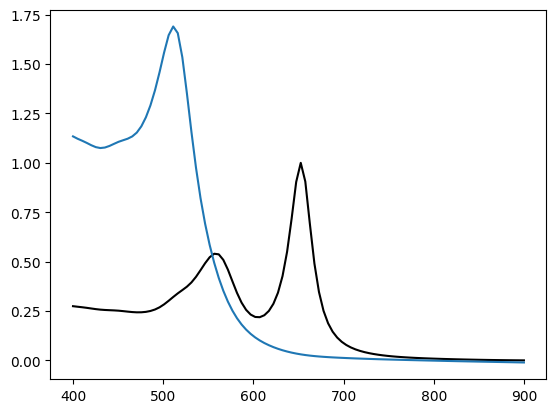

In [ ]:
fig, ax = plt.subplots()
yt_normalized = ((yt-min(yt))/(max(yt)-min(yt))).detach().numpy()
ax.plot(xt.detach().numpy(), yt_normalized, color="k")
for i in range(NUM_RESTARTS):
    ax.plot(xt.detach().numpy(), spectra[i,...].detach().numpy())
plt.show()